# TUTORIAL - Analysis of a CD protocol in a tree network

In this tutorial we explain how to use the basic functions to run the simulation and extract useful results. In particular:
 - we show how to run the simulation for a fixed set of parameters and analyze the evolution of the system over time;
 - we explain how to optimize the performance of the protocol.

In [1]:
import main_cd as main

# Other modules
import numpy as np
import numpy.matlib as npm
import json
import matplotlib.pyplot as plt
from matplotlib import rc
import copy
import warnings
import scipy
from scipy import sparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmn
import importlib as imp
import os
import random

# Save figures in the notebook with decent quality
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Create figures directory if needed
try:
    os.mkdir('figs')
except FileExistsError:
    pass

---

## Simulation: system evolution over time

---

### Inputs

In [2]:
imp.reload(main)

## PROTOCOL
protocol = 'srs' # Currently only 'srs' has been debugged

## TOPOLOGY
# Use any function main.adjacency_*() to define a topology.
# Here we use a squared lattice (with hard boundary conditions)
# with 9 nodes as an example.
l = 3
n = int(l*l)
A = main.adjacency_squared_hard(l)
topology = 'squared_hard'

## HARDWARE
p_gen = 0.5 # Probability of successful entanglement generation
p_swap = 1 # Probability of successful swap
qbits_per_channel = 5 # Number of qubits per node per physical neighbor

## SOFTWARE
q_swap = 0.12 # Probability of performing swaps in the SRS protocol
max_links_swapped = 4 # Maximum number of elementary links swapped
p_cons = 0.1 # Probability of virtual neighbors consuming a link per time step
F_app = 0.6 # Minimum fidelity required by the background application

## CUTOFF
# The cutoff is here chosen arbitrarily. To find a physically meaningful value,
# one should use the coherence time of the qubits and the fidelity of newly
# generated entangled links. A valid approach is to use a worst-case model
# as in Iñesta et al. 'Optimal entanglement distribution policies in homogeneous
# repeater chains with cutoffs', 2023.
cutoff = 20

## SIMULATION
data_type = 'avg' # Store only average (and std) values instead of all simulation data
N_samples = 100 # Number of samples
total_time = int(cutoff*5) # Simulation time
plot_nodes = [0,4,5] # We will plot the time evolution of these nodes
randomseed = 2
np.random.seed(randomseed)

### Run simulation

The simulation can be run using the example code below. To run many instances of the simulation (e.g., with different sets of parameters), we provide a separate Python file, `run_cd.py` that can be executed independently (it runs the simulation and saves the results).

In [3]:
# Check if data exists
if not main.check_data_cd(protocol, data_type, topology, n, p_gen,
            q_swap, p_swap, p_cons, cutoff, max_links_swapped,
            qbits_per_channel, N_samples, total_time, randomseed):

    # Run simulation
    data = main.simulation_cd(protocol, A, p_gen, q_swap, p_swap,
                                p_cons, cutoff, max_links_swapped,
                                qbits_per_channel, N_samples,
                                total_time,
                                progress_bar='notebook',
                                return_data=data_type)
    # Save data
    main.save_data_cd(data, protocol, data_type, topology, n,
                    p_gen, q_swap, p_swap, p_cons, cutoff,
                    max_links_swapped, qbits_per_channel, N_samples,
                    total_time, randomseed)
    
    print('Done! Data saved!')

else:
    print('Data already exists!')

Data already exists!


### Plot time traces

Here, we plot the average virtual degree over $N$ samples, $\overline{k_{i,N}}(t)$, and the average virtual neighborhood size, $\overline{v_{i,N}}(t)$, of a few nodes. The shaded regions correspond to $\pm$ one standard deviation.

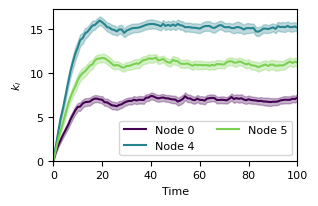

Maximum std: 3.717
Maximum standard error: 0.372


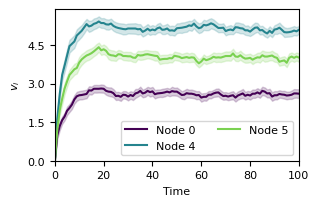

Maximum std: 1.261
Maximum standard error: 0.126


In [4]:
main.plot_avgs(plot_nodes, protocol, data_type, topology, n, p_gen,
                q_swap, p_swap, p_cons, cutoff, max_links_swapped,
                qbits_per_channel, N_samples, total_time, randomseed)

---

## Protocol optimization

---

Now, we take $lim_{t\rightarrow\infty} \mathbb{E}[v_i(t)]$ as the objective function that we want to optimize. In this example, we will assume that the steady state has been reached and we can estimate the objective function as $lim_{t\rightarrow\infty} \mathbb{E}[v_i(t)] \approx \overline{v_{i,N}}(t_{\mathrm{sim}})$, where $t_\mathrm{sim}$ is the total simulation time.
To optimize $\overline{v_{i,N}}(t_{\mathrm{sim}})$, we run the simulation $N$ times for different values of the protocol parameter $q_\mathrm{swap}$.

### Inputs

We use the same inputs as before, but now we also need to specify the values of `q_swap` that we want to consider.

In [5]:
varying_array = np.arange(0,1,0.1)
varying_param = 'q_swap'

### Run simulation

In [6]:
for q_swap in tqdmn(varying_array, leave=False):
    # Check if data exists
    if not main.check_data_cd(protocol, data_type, topology, n, p_gen,
                q_swap, p_swap, p_cons, cutoff, max_links_swapped,
                qbits_per_channel, N_samples, total_time, randomseed):

        # Run simulation
        data = main.simulation_cd(protocol, A, p_gen, q_swap, p_swap,
                                    p_cons, cutoff, max_links_swapped,
                                    qbits_per_channel, N_samples,
                                    total_time,
                                    progress_bar='notebook',
                                    return_data=data_type)
        # Save data
        main.save_data_cd(data, protocol, data_type, topology, n,
                        p_gen, q_swap, p_swap, p_cons, cutoff,
                        max_links_swapped, qbits_per_channel, N_samples,
                        total_time, randomseed)

        print('Done! Data saved!')

    else:
        print('Data already exists!')

  0%|          | 0/10 [00:00<?, ?it/s]

Data already exists!
Data already exists!
Data already exists!
Data already exists!
Data already exists!
Data already exists!
Data already exists!
Data already exists!
Data already exists!
Data already exists!


### Plot

q_swap:   0%|          | 0/10 [00:00<?, ?it/s]

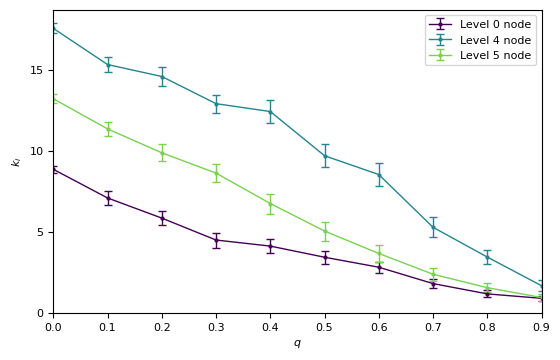

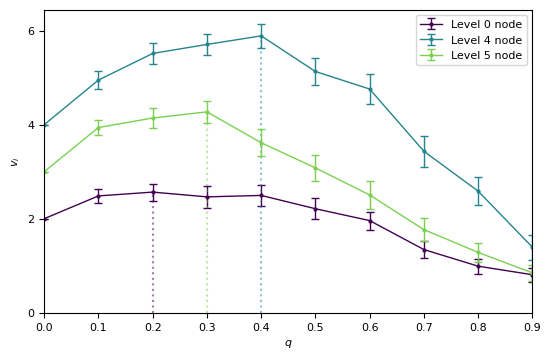

In [7]:
main.plot_avgs_vs_param(plot_nodes, varying_array, varying_param,
                protocol, data_type, topology, n, p_gen, q_swap, p_swap,
                p_cons, cutoff, max_links_swapped, qbits_per_channel,
                N_samples, total_time, randomseed,
                x_cm=16, y_cm=10, save=False)